In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,os,datetime

import tensorflow as tf
import pandas as pd
import seaborn as sns

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split

from keras.models import Model,Sequential
from keras.layers import Dense,Dropout,LSTM,Conv2D,Conv2DTranspose,MaxPooling2D,UpSampling2D,Input,BatchNormalization,Flatten
from keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor

warnings.filterwarnings('ignore')
sns.set()

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('Data\\data1\\all_stocks_5yr.csv',infer_datetime_format=True)

In [3]:
ticker_list = list(set(df['Name'].values))

names = []
ind = []

for k in range(len(ticker_list)):
    ticker = df[df['Name']==ticker_list[k]].sort_values(by='date')['close'].values
    if ticker.shape[0]!=1259: continue
    names.append(ticker_list[k])
    ind.append(ticker)

tickers = np.vstack(ind)
names = np.vstack(names)

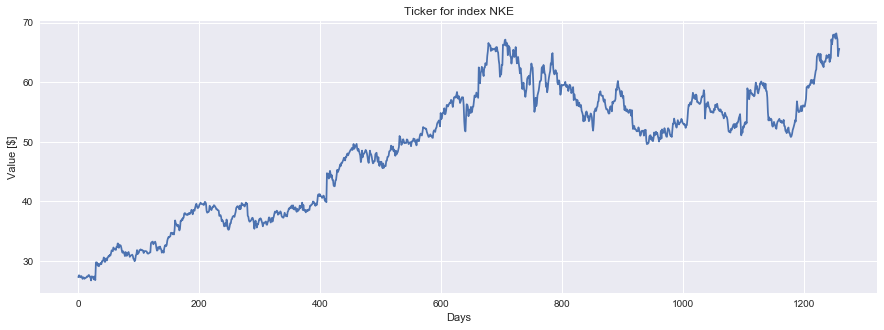

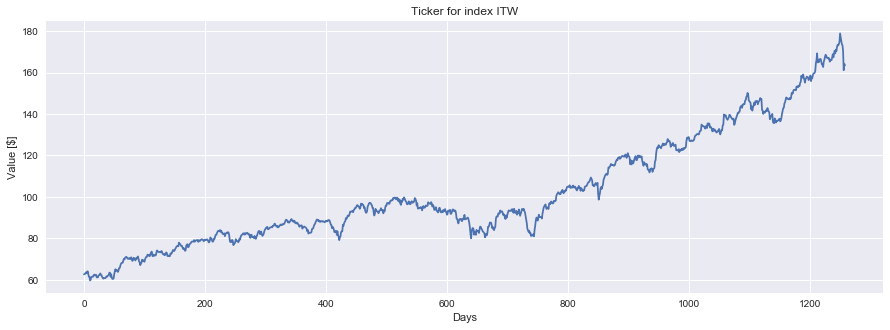

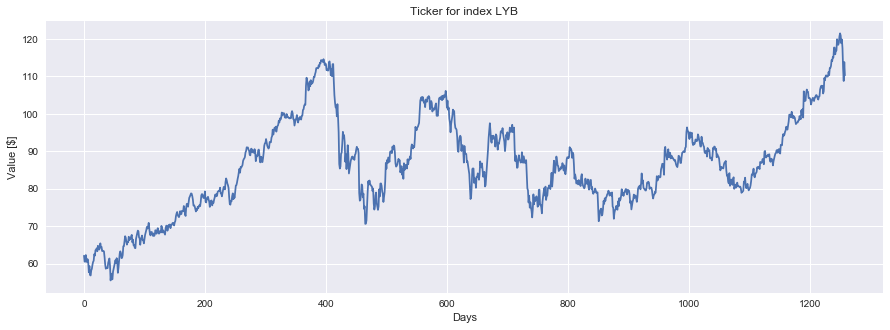

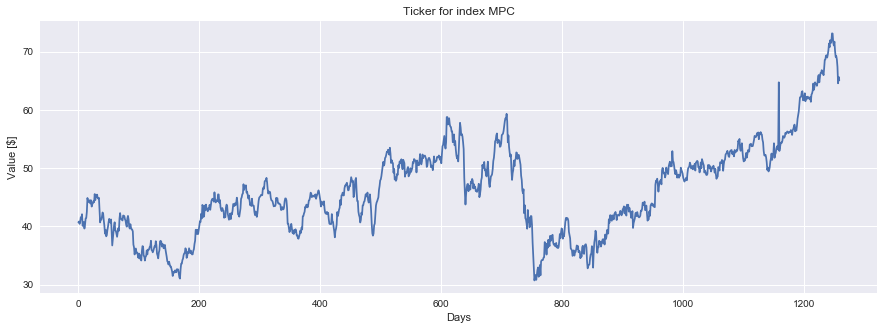

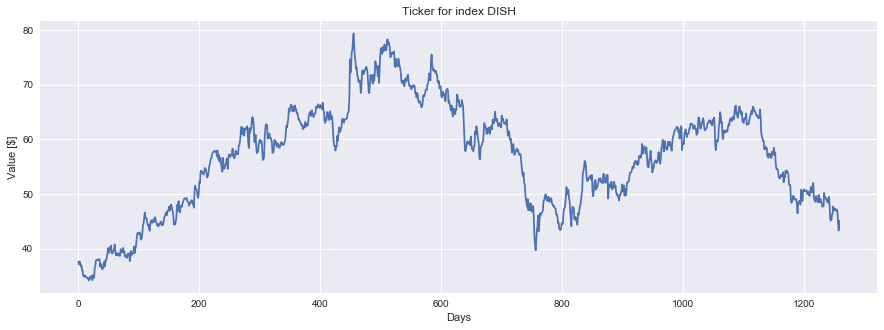

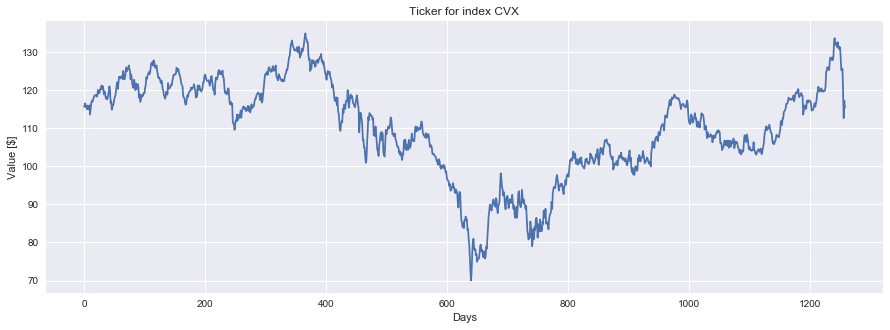

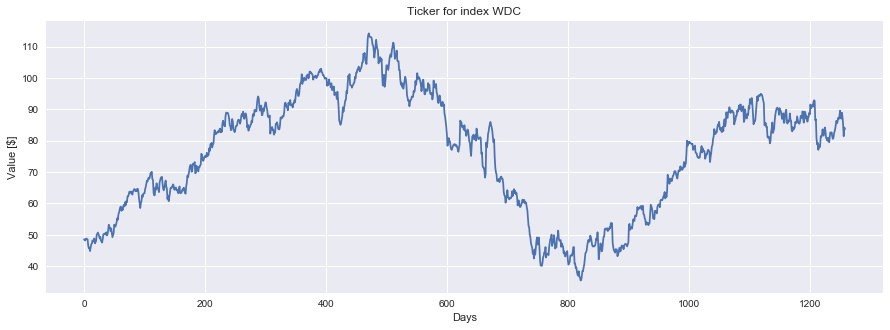

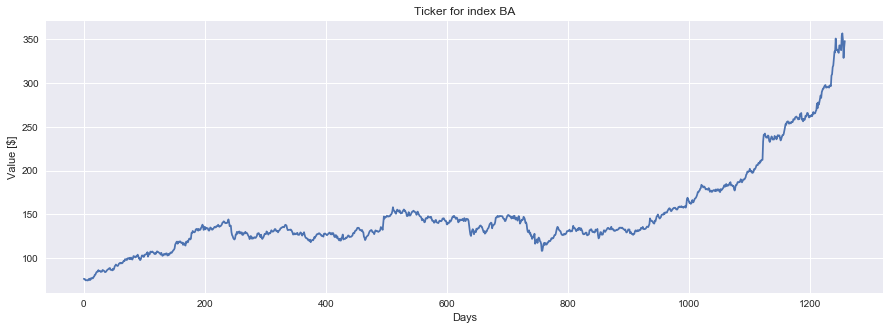

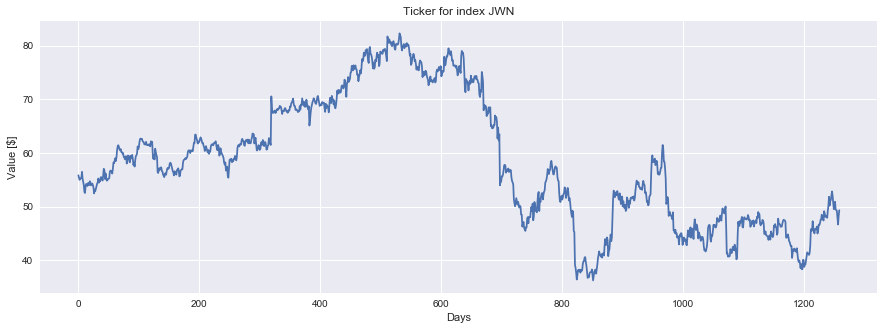

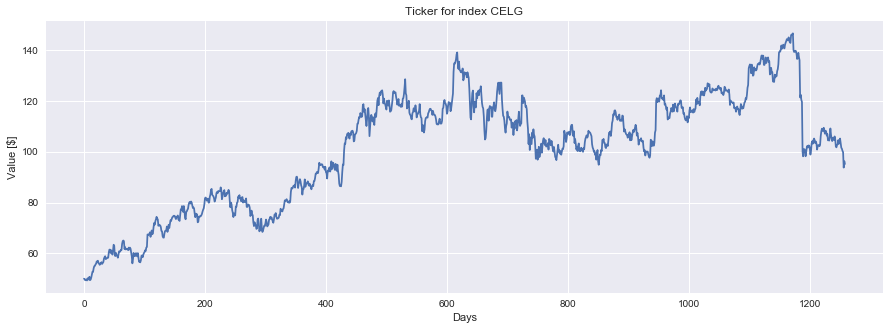

In [4]:
indices = rnd.permutation(np.arange(0,tickers.shape[0]))[:10]

for idx in indices:
    
    fig = plt.figure(figsize=(15,5))
    plt.plot(tickers[idx,:])
    plt.title('Ticker for index '+str(names[idx,0]))
    plt.xlabel('Days')
    plt.ylabel('Value [$]')
    plt.show()

In [5]:
DATA = []

for k in range(tickers.shape[0]):
    for kk in range(0,tickers.shape[1]-59,100):
        t = tickers[k,kk:kk+100]
        t = pp.MinMaxScaler(feature_range=(0,1)).fit_transform(t.reshape(-1,1))
        DATA.append(t)
        
DATA = np.stack(DATA,axis=0)

Xtrain,Xtest = train_test_split(DATA,test_size=0.1)

In [33]:
tf.reset_default_graph()

in0 = tf.placeholder(dtype=tf.float32,shape=(None,100))

#x = tf.contrib.layers.flatten(in0)
x = tf.contrib.layers.fully_connected(inputs=in0,num_outputs=75,activation_fn=tf.nn.relu)
x = tf.contrib.layers.fully_connected(inputs=x,num_outputs=50,activation_fn=tf.nn.relu)
x = tf.contrib.layers.fully_connected(inputs=x,num_outputs=30,activation_fn=tf.nn.relu)

enc = tf.contrib.layers.fully_connected(inputs=x,num_outputs=25,activation_fn=tf.nn.relu)

x = tf.contrib.layers.fully_connected(inputs=enc,num_outputs=30,activation_fn=tf.nn.relu)
x = tf.contrib.layers.fully_connected(inputs=x,num_outputs=50,activation_fn=tf.nn.relu)
x = tf.contrib.layers.fully_connected(inputs=x,num_outputs=75,activation_fn=tf.nn.relu)

dec = tf.contrib.layers.fully_connected(inputs=x,num_outputs=100,activation_fn=tf.nn.relu)

mse = tf.reduce_mean(tf.subtract(in0,dec)**2)
opt = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = opt.minimize(mse)

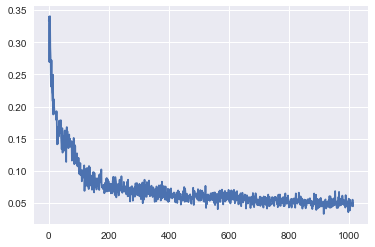

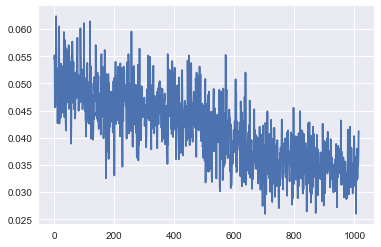

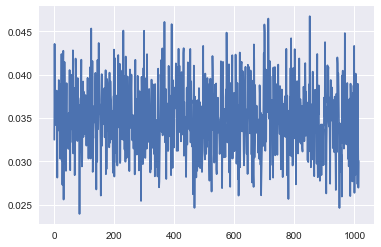

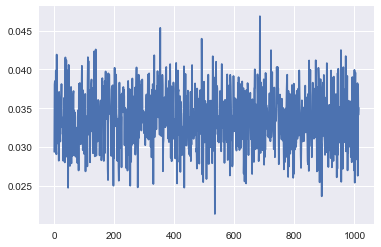

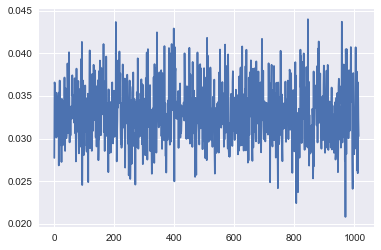

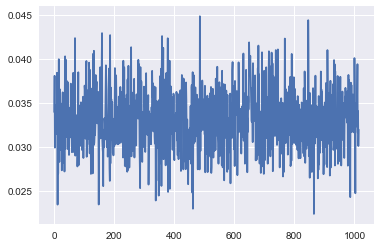

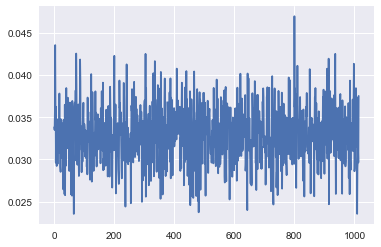

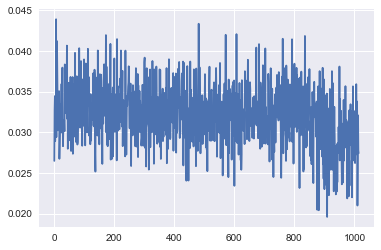

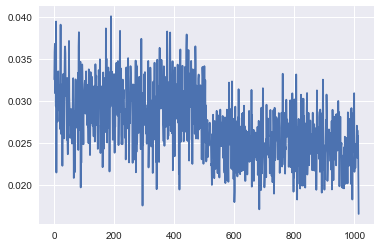

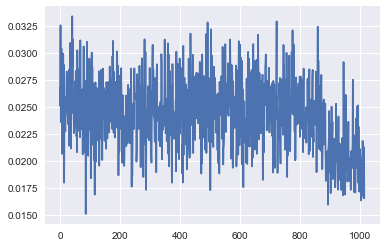

In [34]:
saver = tf.train.Saver()

with tf.Session() as sess:
    
    num_epochs = 10
    batch_size = 5
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        
        epoch_mse = []
        
        indices = rnd.permutation(np.arange(0,Xtrain.shape[0]))
        k = 0
        while True:
            
            try:
                batch_indices = indices[k:(k+batch_size)]
                k += batch_size
                Xbatch = Xtrain[batch_indices,:,0].reshape(batch_size,Xtrain.shape[1])
            except:
                break
                
            [s_mse,s_train_step] = sess.run([mse,train_step],feed_dict={
                in0: Xbatch
            })
            epoch_mse.append(s_mse)
            
        plt.plot(epoch_mse)
        plt.show()
            
    save_path = saver.save(sess,'.\\Models\\ENV_COMPv06model.ckpt')

In [ ]:
tf.reset_default_graph()
saver = tf.train.Saver()

with tf.Session() as sess:
    
    saver.restore(sess,'.\\Models\\ENV_COMPv06model.ckpt')